## [Exercise](https://www.learnpytorch.io/01_pytorch_workflow/#exercises)

*Note: For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).*

In [49]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

# Setting device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


## 1. Create a straight line dataset using the linear regression formula `(weight * X + bias)`
  - Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
  - Split the data into 80% training, 20% testing.
  - Plot the training and testing data so it becomes visual.

In [50]:
weights = 0.3
bias = 0.9

start, end, step = 0, 2, 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weights * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.9000],
         [0.9060],
         [0.9120],
         [0.9180],
         [0.9240]]))

In [51]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(80, 20)

In [52]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(8,4))

  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions Data')

  plt.legend();

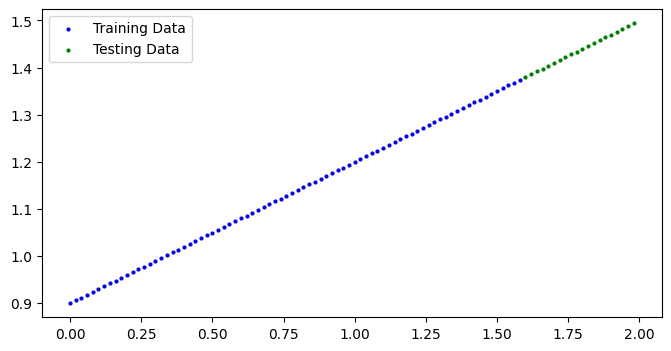

In [53]:
plot_predictions()

## 2. Build a PyTorch model by subclassing `nn.Module`
  - Inside should be a randomly initialized `nn.Parameter()` with requires_grad=True, one for weights and one for bias.
  - Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
  - Once you've constructed the model, make an instance of it and check its `state_dict()`.

*Note: If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can*

In [54]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Linear(in_features = 1,
                            out_features = 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear(x)

torch.manual_seed(42)
model = LinearRegression()

model, model.state_dict()

(LinearRegression(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear.weight', tensor([[0.7645]])),
              ('linear.bias', tensor([0.8300]))]))

In [55]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively
  - Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  - Write a training loop to perform the appropriate training steps for 300 epochs.
  - The training loop should test the model on the test dataset every 20 epochs.

In [56]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [57]:
torch.manual_seed(42)

epochs = 300

# Placing data on CUDA
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []

# Train Loop
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  if epoch % 20 == 0 or epoch == epochs - 1:
    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)

      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f'Epoch: {epoch} ---- Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}')

Epoch: 0 ---- Train Loss: 0.3045 | Test Loss: 0.7396
Epoch: 20 ---- Train Loss: 0.1400 | Test Loss: 0.3841
Epoch: 40 ---- Train Loss: 0.0931 | Test Loss: 0.2102
Epoch: 60 ---- Train Loss: 0.0737 | Test Loss: 0.1480
Epoch: 80 ---- Train Loss: 0.0555 | Test Loss: 0.1085
Epoch: 100 ---- Train Loss: 0.0373 | Test Loss: 0.0723
Epoch: 120 ---- Train Loss: 0.0191 | Test Loss: 0.0362
Epoch: 140 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 160 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 180 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 200 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 220 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 240 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 260 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 280 ---- Train Loss: 0.0046 | Test Loss: 0.0196
Epoch: 299 ---- Train Loss: 0.0116 | Test Loss: 0.0045


## 4. Make predictions with the trained model on the test data
  - Visualize these predictions against the original training and testing data.
  
*(Note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot)*

In [58]:
model.eval()
with torch.inference_mode():
  y_preds = model(X_test)

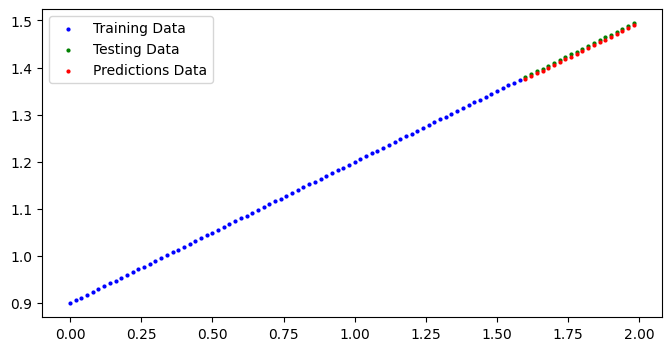

In [59]:
plot_predictions(predictions = y_preds.to('cpu'))

## 5. Save your trained model's `state_dict()` to file
  - Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  - Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [60]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents = True, exist_ok =True)

model_name = '01_LinearRegressionV2.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj = model.state_dict(),
           f = model_save_path)
print('Saved Successfully')

Saving model to: models/01_LinearRegressionV2.pth
Saved Successfully


In [61]:
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load(model_save_path))

# Transfer loaded model to CUDA
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [62]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')